<a href="https://colab.research.google.com/github/gowen100/Jane-Street-Solutions/blob/master/JaneSt_Feb18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from skimage.morphology import label

In [2]:
# Working through the hooks puzzles.
# starting from hooks #4
# More valid hook placements here and will be hard to solve with backtracking
# Can I do something with linear programming ????


url='https://www.janestreet.com/puzzles/hooks-5/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:]))

The grid presented here can be partitioned into 9 L-shaped “hooks”. The largest is 9-by-9 (contains 17 squares), the next largest is 8-by-8 (contains 15 squares), and so on. The smallest hook is just a single square. Find where the hooks are located, and place nine 9’s in the largest hook, eight 8’s in the next-largest, etc., down to one 1 in the smallest hook. The filled squares must form a connected region. (Squares are “connected” if they are orthogonally adjacent.) A number outside the grid indicates the sum of the first consecutive block of filled squares when looking in that direction. (As shown in the example.) Furthermore, every 2-by-2 region must contain at least one unfilled square. The answer to this puzzle is the product of the areas of the connected groups of empty squares in the completed grid.


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/06/20190603_hooks_5.png" width="300" height="300">

In [3]:
#Setup the constraints
top_labels  = [41, 8, 0, 0,14, 0,15, 0, 0]
bot_labels  = [ 0, 9, 0,17, 0,15, 0,35, 0]
left_labels = [ 0, 0,25, 0,15, 0,26, 0, 0]
right_labels =[25, 0, 0, 0,10, 0, 0, 0,27]


In [13]:
class Matrix():
    def __init__(self,top_labels,bot_labels,left_labels,right_labels):
        self.top_labels = top_labels
        self.bot_labels = bot_labels
        self.left_labels = left_labels
        self.right_labels = right_labels
        self.potential_grids = [[-9,np.ones((9,9),dtype=int)*-1,[0,0,9,9]]] # list of all grids not yet ruled out.[Level,grid,coordinates of the grid yet to be filled]
        self.solution = []
        self.splits =  [list(i) for i in itertools.product([0, 1], repeat=9)]
     
    ########################################################################################
    # Code to get the initial valid grids

    def add_layer(self,grid,coords,lvl,alignment):
        row_start,col_start,row_end, col_end = coords
    
        if alignment == 0:
            grid[row_start:row_end,col_start] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_start +=1
    
        if alignment == 1:
            grid[row_start:row_end,col_start] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_start +=1 

        if alignment == 2:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_end -=1
        
        if alignment == 3:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_end -=1 
    
        coords = [row_start,col_start,row_end, col_end]
        
        return grid,coords    
   
    def check_grid(self,grid):
        isValid = 1
        for i in range(9):
            row = grid[i,:]
            col = grid[:,i]
            if -1 not in row:
                    isValid *= self.check_line(row,self.left_labels[i],self.right_labels[i])
            if -1 not in col:
                    isValid *= self.check_line(col,self.top_labels[i],self.bot_labels[i]) 
                    
            
        return isValid
                    
    def check_line(self,line,param_start,param_end):
        for split in self.splits:
            test = line * split
            if self.valid_line(test,param_start):
                if self.valid_line(test[::-1],param_end):
                    return 1
        return 0
    

    def valid_line(self,pos,param):
        if param == 0:
            return True
        total = 0 
        block = 0
        inblock =0
        for p in pos:
            if p !=0:
                block += p
                inblock = 1
            else:
                if inblock == 1:
                    total += block
                    block = 1
                    break
                    
        if block > 1:
            total +=block
        if total == param:
            return True
        else:
            return False
        
    def fill_rest(self,grid,hooks):
        for row in range(9):
            if -1 in grid[row,:]:
                for split in self.splits : 
                    if self.possible(split,row,grid,hooks):
                        grid[row,:] = split
                        self.fill_rest(grid,hooks)
                        grid[row,:] =np.ones(9)*-1
                return
        sol_print(grid,hooks)              
                           
           
            
    def possible(self,split,row,grid,hooks):
        test = dcopy(grid)
        test[row,:] = split
        test = test*hooks
    
    #check the placement doesn't break connectivity
        if np.max(label(test!=0,connectivity=1)) > 1:
            return False
                
        #check rows   
        check_row = test[row,:]
        if not self.valid_line(check_row,self.left_labels[row]):
            return False
        if not self.valid_line(check_row[::-1],self.right_labels[row]):
            return False
    
    # check counts
        for num in range(2,10):
            if np.sum(test == num) > num:
                return False
            
    #check 2 by 2
        if self.twobytwo(test):
            return False
        
    #check columns
        for col in range(9):
            if self.top_labels[col] !=0:
                col_tot =0
                block = 0
                for i in range(9):
                    num = test[i,col]
                    if num > 0:
                        if block <2:
                            col_tot +=num
                            block =1
                    else:
                        if num < 0:
                            if col_tot > self.top_labels[col]:
                                return False
                    if num == 0:
                        if block ==1:
                            block =2
                            if col_tot != self.top_labels[col]:
                                return False
        
        
    # final checks if the placement completes the grid    
        if np.sum(test < 0) ==0:
        #check counts
            for num in range(2,10):
                if np.sum(test == num) != num:
                    return False
            
    
        #check rows and columns again
            for i in range(9):
                row = test[i,:]
                col = test[:,i]
                if not self.valid_line(col,self.top_labels[i]):
                    return False             
                if not self.valid_line(col[::-1],self.bot_labels[i]):
                    return False     
        return True      
       
    def twobytwo(self,grid):
        for i,j in itertools.product(range(9),range(9)):
            if (i > 0 and j > 0 and 
                grid[i,j] > 0 and
                grid[i-1,j-1] > 0 and 
                grid[i-1,j] > 0 and 
                grid[i,j-1] > 0):
                    return True
    
            if (i > 0 and j < 6 and
                grid[i,j] > 0 and
                grid[i-1,j+1] > 0 and 
                grid[i-1,j] > 0 and 
                grid[i,j+1] > 0):
                    return True
    
            if (i < 6 and j > 0 and
                grid[i,j] > 0 and
                grid[i+1,j-1] > 0 and 
                grid[i+1,j] > 0 and 
                grid[i,j-1] > 0):
                    return True

    
            if (i < 6 and j < 6 and
                grid[i,j] > 0 and
                grid[i+1,j+1] > 0 and 
                grid[i+1,j] > 0 and 
                grid[i,j+1] > 0):
                    return True
    
        return False
    
    
    
    
    def solve(self):
           
        while len(self.potential_grids) > 0:
            
            temp_grid = self.potential_grids.pop(0)
            #create the potential rotations at the given level
            rotations = []
        
            for alignment in range(4):
                lvl,grid,coords = dcopy(temp_grid)
                grid,coords = self.add_layer(grid,coords,-lvl,alignment)
                if lvl != -1 :
                    rotations.append([lvl+1,grid,coords])
                else:
                     rotations = [[lvl+1,grid,coords]]
    
            #check valid grids (where the sum can be made from available digits) and save the ones that work
            for i in range(len(rotations)):
                lvl,g,coords = rotations[i]
                if self.check_grid(g):
                    if lvl !=0:    
                        self.potential_grids.append([lvl,g,coords])
                    else:
                        self.solution.append(g)
                        


                        
        print("There are {} valid hook placements".format(len(self.solution)))
        self.solution =[np.array([[8,8,8,8,8,8,8,8,9],
                                  [8,7,7,7,7,7,7,7,9], 
                                  [8,7,6,4,4,4,4,5,9],
                                  [8,7,6,3,3,3,4,5,9],
                                  [8,7,6,3,2,1,4,5,9],
                                  [8,7,6,3,2,2,4,5,9],
                                  [8,7,6,5,5,5,5,5,9],
                                  [8,7,6,6,6,6,6,6,9],
                                  [9,9,9,9,9,9,9,9,9]
             ])]   
        


        #solve each grid in the cut down list
        forced_grids = []
        for i in range(len(self.solution)):
            print("Checking: ",i)
            hooks = self.solution[i]
            #print(hooks)
            forced_grid =np.ones((9,9),dtype= int)*-1
            #forced_grid = test_grid
            self.fill_rest(forced_grid,hooks)
            
        
#########################
# Code to print in a "nice" format
                            
def sol_print(solved,matrix):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x = np.array((solved*matrix).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(matrix,annot=x,cbar=False,cmap="Set3_r",fmt="",linewidths=0.25)
    ax.axis("off")
    
    

There are 135 valid hook placements
Checking:  0

 Solution took 1432.1902 seconds



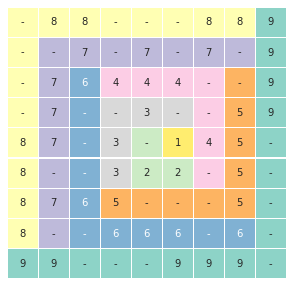

In [14]:
start = time.perf_counter()
test = Matrix(top_labels,bot_labels,left_labels,right_labels)
test.solve()
stop =  time.perf_counter()
print('\n Solution took {:0.4f} seconds\n'.format((stop-start)))

### Puzzle solution
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/07/20190718_hooks_5_sol.png" width="300" height="400">

In [ ]:
test_grid =np.array([[0,1,1,0,0,0,1,1,1],
                     [0,0,1,0,1,0,1,0,1],
                     [0,1,1,1,1,1,0,0,1],
                     [0,1,0,0,1,0,0,1,1],
                     [1,1,0,1,0,1,1,1,0],
                     [1,0,0,1,1,1,0,1,0],
                     [1,1,1,1,0,0,0,1,0],
                     [1,0,0,1,1,1,0,1,0],
                     [1,1,0,0,0,1,1,1,0]
             ])

test_hook =np.array([[8,8,8,8,8,8,8,8,9],
                     [8,7,7,7,7,7,7,7,9],
                     [8,7,6,4,4,4,4,5,9],
                     [8,7,6,3,3,3,4,5,9],
                     [8,7,6,3,2,1,4,5,9],
                     [8,7,6,3,2,2,4,5,9],
                     [8,7,6,5,5,5,5,5,9],
                     [8,7,6,6,6,6,6,6,9],
                     [9,9,9,9,9,9,9,9,9]
             ])

In [ ]:
sol_print(test_grid,test_hook)